O problema analizado é o caixeiro viajante com cidades dispostas ao longo de uma esctrela. O problema é equivalente ao de cidades dispostas ao longo de um circulo, mas com raio variável. Os mínimos continuam sendo os casos em que as cidades seguem ordem crescente ou decrescente.

In [1]:
using Random
using LinearAlgebra
using Plots
using TimerOutputs
using Waveforms
using Distributed;
using ProgressMeter
using Profile

using Dagger

#Definiçoes

const cidades = 150
const raioBase = 0.8506508

const fatorNormalizacao = 1
const raioPentagono = (raioBase .+ 0.2*trianglewave.(10*pi.*(0:cidades-1)./(cidades)) .+ 0.2)
const x = raioPentagono.*[cos.(2 .* pi .* (0:cidades-1) ./ cidades) sin.(2 .* pi .* (0:cidades-1) ./ cidades)];

const HMenorJ = false
const NList = [10^5]
const T0List = [0.2]
const KmaxList = 100
const seeds = 3
const ordemOtima = 1:cidades
const ploting = true

true

In [2]:
# bOrdem = ordemOtima

# plot([0], [0], seriestype = :scatter, xlim=[-1.5, 1.5], ylim=[-1.5, 1.5], size = (500, 500), grid = true)
# xt(t) = sin(t)*raioBase
# yt(t) = cos(t)*raioBase
# plot!(xt, yt, 0, 2*pi, leg=false)
# plot!(x[:, 1], x[:, 2], seriestype = :scatter, mode="markers+text", text=0:cidades-1)

# quiver!(x[bOrdem, 1],x[bOrdem, 2],quiver=(x[[bOrdem[2:end]; bOrdem[1]], 1] - x[bOrdem, 1],x[[bOrdem[2:end]; bOrdem[1]], 2] - x[bOrdem, 2])) 

In [3]:
# addprocs(5)

In [4]:
# O custo é a distancia total percorrida
custosTemp = zeros(Float64, cidades, cidades)

for i = 1:cidades
    for j in 1:cidades
        custosTemp[i, j] = norm(x[i, :]-x[j, :])
    end
end

const custos = custosTemp;

In [5]:
function J(ordem)
    distTot = 0.0
    for i = 2:cidades
        distTot += custos[ordem[i], ordem[i-1]]    
    end
    
    distTot += custos[ordem[end], ordem[1]]
    
    return distTot
end

J (generic function with 1 method)

In [6]:
Jotimo = J(ordemOtima)

7.650882813515685

In [7]:
function SA(seed::Int64, T0::Float64, N::Int64, Kmax::Int64, ploting::Bool)
    Random.seed!(seed);
    
    Jatual = 1e4
    Jmin = Jatual
    distancias = []
    temperaturas = []
    if ploting
        distancias = zeros(Float64, Kmax*N, 1)
        temperaturas = zeros(Float64, Kmax*N, 1)
    end
    T = T0
    its = 0
    minIts = 0
    bestK = 0
    
    # Ordem de caminhos inicial aleatoria
    ordem = shuffle(1:cidades)
    ordemHat = copy(ordem)
    ordemMin = copy(ordem)
    for k = 1:Kmax
        for n = 1:N
            its += 1
            # Troca duas cidades de ordem de maneira aleatoria, exceto a primeira que é sempre a mesma
            idx = rand((1:cidades))
            idx2 = rand((1:cidades))
            while idx2 == idx
                idx2 = rand(1:cidades)
            end
            copy!(ordemHat, ordem)
            ordemHat[idx], ordemHat[idx2] = ordem[idx2], ordem[idx]

            Jit = J(ordemHat)

            q = exp((Jatual-Jit)/T)
            r = rand()

            if r < q
                copy!(ordem, ordemHat)
                Jatual = Jit
            end    

            if Jit < Jmin
                Jmin = Jit
                copy!(ordemMin, ordemHat)
                minIts = its
                bestK = k
                if (Jmin - Jotimo) < 0.001
                    if ploting
                        distancias[its] = Jit
                        temperaturas[its] =  T
                    end
#                     println("\nMinimo Encontrado")
                    return ordemMin, distancias, temperaturas, Jmin, k, minIts
                end
            end
            if ploting
                distancias[its] = Jit
                temperaturas[its] =  T
            end
        end
        T = T0/(log2(1 + k))

        if HMenorJ
            copy!(ordem, ordemMin)
        end
    end
    return ordemMin, distancias, temperaturas, Jmin, bestK, minIts
end

SA (generic function with 1 method)

In [8]:
bestCFG = 0
bestJ = 1e4
allOrdemMin = []
allDistancias = []
allTemperaturas = []
allJmin = []
allK = []
allMinIts = []
bestTempo = 1e4
bestKmax = 0
bestSeed = 0
bestN = 0
bestT0 = 0
bestOtimo = false
its = 1

# daggers = []
# for seed = seeds
#     push!(daggers, Dagger.@spawn SA(seed, T0, N, Kmax));
# end
@showprogress for seed = seeds
    for T0 = T0List
        for Kmax = KmaxList
            for N = NList
                time = @elapsed begin
            #         ordemMin, distancias, temperaturas, Jmin, k, minIts = fetch(daggers[its])
                    ordemMin, distancias, temperaturas, Jmin, k, minIts =SA(seed, T0, N, Kmax, ploting);
#                     println();
                end
#                 println("Tempo: ", time)
                push!(allOrdemMin, ordemMin)
                push!(allDistancias, distancias)
                push!(allTemperaturas, temperaturas)
                push!(allJmin, Jmin)
                push!(allK, k)
                push!(allMinIts, minIts)  
                otimo = false
                if (Jmin - Jotimo) < 0.001
                    otimo = true
                end
                if Jmin < bestJ || ((Jmin - bestJ) < 0.001 && time < bestTempo)
                    bestJ = Jmin
                    bestCFG = its
                    bestSeed = seed
                    bestTempo = time
                    bestT0 = T0
                    bestN = N
                    bestKmax = Kmax
                    bestOtimo = otimo
                end
                
                resultados = string(cidades, ",", T0 ,"," , N , "," , Kmax , "," , Jmin , "," , time, ",", HMenorJ, "," , seed , ",", otimo, "\n")
#                 println(resultados)
                open("resultados_all.csv","a") do io
#                     write(io, resultados)
                end;
                its += 1
            end
        end
    end
end
println("Melhor Seed: ", bestSeed)
println("Melhor J: ", bestJ)
println("J Otimo: ", Jotimo)
println("Melhor k: ", allK[bestCFG])

Melhor Seed: 3
Melhor J: 7.650882813515684
J Otimo: 7.650882813515685
Melhor k: 99


Jmin: 7.650882813515684
Jotimo: 7.650882813515685


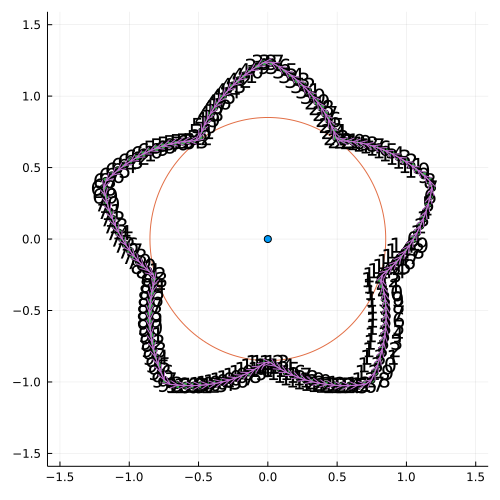

In [9]:
if ploting
    bOrdem = allOrdemMin[bestCFG]
    bDistancias = allDistancias[bestCFG]
    bTemperaturas = allTemperaturas[bestCFG]

    println("Jmin: ", bestJ)
    println("Jotimo: ", Jotimo)
    plot([0], [0], seriestype = :scatter, xlim=[-1.5, 1.5], ylim=[-1.5, 1.5], size = (500, 500), grid = true)
    xt(t) = sin(t)*raioBase
    yt(t) = cos(t)*raioBase
    plot!(xt, yt, 0, 2*pi, leg=false)
    plot!(x[:, 1], x[:, 2], seriestype = :scatter, mode="markers+text", text=0:cidades-1)

    quiver!(x[bOrdem, 1],x[bOrdem, 2],quiver=(x[[bOrdem[2:end]; bOrdem[1]], 1] - x[bOrdem, 1],x[[bOrdem[2:end]; bOrdem[1]], 2] - x[bOrdem, 2])) 
end

In [16]:
using Measures
# max = 0
# for i = 1:length(bDistancias)
#     if abs(bestJ - bDistancias[i]) < 0.001
#         max = i
#         break
#     end
# end

otimo = false
dp = bDistancias[bDistancias .> 0]
tp = bTemperaturas[bDistancias .> 0]
if (bestJ - Jotimo) < 0.001
    otimo = true
end

if ploting
    step = 1000
    plot(1:step:length(dp), dp[1:step:end], label = "J", lw = 3, size = (800, 400),xtickfontsize=12,ytickfontsize=12, legendfontsize=10,legend=:topleft, margin = 12mm)
    
    plot!(1:step:length(dp), ones(length(dp[1:step:end]), 1)*Jotimo, label = "Jotimo", lw = 3)
    plot!(twinx(), 1:step:length(dp), tp[1:step:end], label = "Temperaturas", lw = 3, color=:green,xticks=:none,ytickfontsize=12, legendfontsize=12)
end
# xlabel!("Iterações")

# ylabel!("Custo")
savefig(string("custo_", cidades, HMenorJ, ".png"))


In [11]:
if otimo && ploting
    savefig(string("custo_", cidades, HMenorJ, ".png"))
end

In [12]:

# header: C,T,N,Kmax,Jmin,Tempo,HMenorJ,O
resultados = string(cidades, ",", bestT0 ,"," , bestN , "," , bestKmax , "," , bestJ , "," , bestTempo, ",", HMenorJ, "," , bestSeed , ",", bestOtimo, "\n")
println(resultados)

open("resultados_melhor.csv","a") do io
#     write(io, resultados)
end;

150,0.2,100000,100,7.650882813515684,1.8828898,false,3,true

